In [90]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

In [91]:
# import optiver2023

In [92]:
raw_data = pd.read_csv('train.csv')

MemoryError: Unable to allocate 256. KiB for an array with shape (32768,) and data type int64

In [ ]:
raw_data[raw_data['target'].isna()]

# Nasdaq Rules:
![rules](nasdaq_MOC.png)
# Data Exploration
## data missing:
Not all stock IDs exist in every time bucket -> the longer the missing time buckets, the more likely the stock experiences a large volatility. 
time_id +1 = 10 seconds
row_id = date_id _ real_time _ stock_id
date_id: 0-480
seconds in a trading day: 540 

starting from date_id = 295, the data will contain stock id of 200 
but at day 320 the numbers of stock drops to 199, then come back. probably stock stop trading. could happen later on in the testing set. 

Far price and near prices are features only available after time id of 30.

imbalance size have many outliers, log transformation is needed

wap is not general definition of wap, it is the order book weighted average price.



# What's our target?

In [68]:
raw_data['target'].describe()

count    5.237892e+06
mean    -4.756125e-02
std      9.452860e+00
min     -3.852898e+02
25%     -4.559755e+00
50%     -6.020069e-02
75%      4.409552e+00
max      4.460704e+02
Name: target, dtype: float64

In [69]:
raw_data['target'].skew()

0.2046688027984725

In [70]:
raw_data['target'].kurtosis()

22.5579700297313

In [71]:
def clipping(x):
    # clip the first and last 1% of the data
    x = x.copy()
    clipping_pct = 0.005
    return np.clip(x.dropna(), np.quantile(x.dropna(), clipping_pct), np.quantile(x.dropna(), 1-clipping_pct))

In [72]:
def standard_transformation(x):
    x = x.copy()
    return (x-x.mean())/x.std()

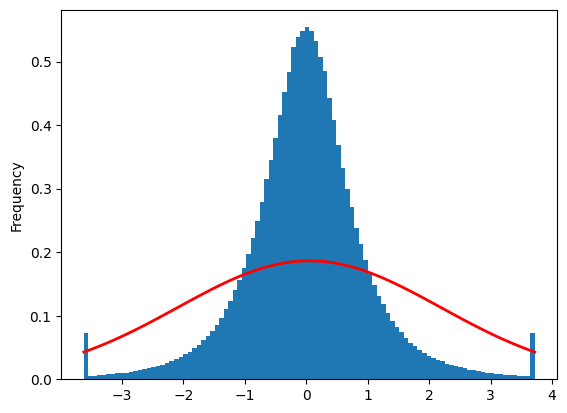

In [73]:
x = standard_transformation(clipping(raw_data['target']))
x.plot(kind = 'hist', bins = 100, density=True)
xmin, xmax = x.min(),x.max()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, x.mean(), x.std())
  
plt.plot(x, p, 'r', linewidth=2)

In [74]:
right_tail = raw_data[raw_data['target'] > raw_data['target'].quantile(0.99)]
left_tail = raw_data[raw_data['target'] < raw_data['target'].quantile(0.01)]

<Axes: ylabel='Frequency'>

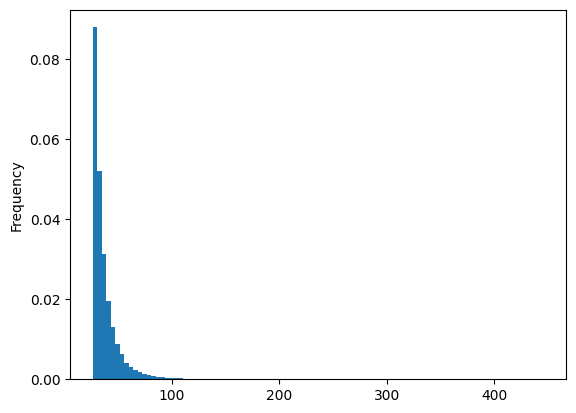

In [75]:
(right_tail['target']).plot(kind = 'hist', bins = 100, density=True)

<Axes: ylabel='Frequency'>

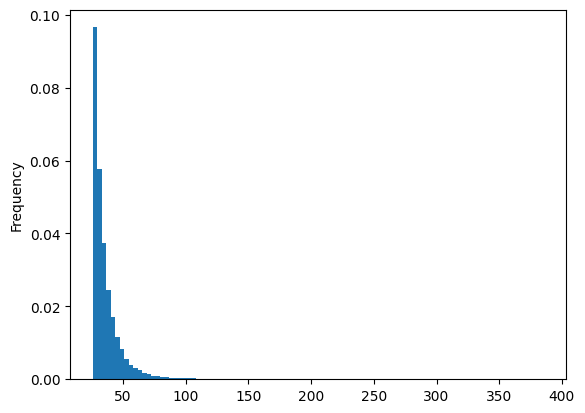

In [76]:
(-left_tail['target']).plot(kind = 'hist', bins = 100, density=True)

Extreme kurtosis , not to much of a skewness, many event happens at the tail. wonder if those events have a connection with time (i.e. the last 10 seconds of the period/at the very beginning of the period)

<Axes: xlabel='seconds_in_bucket'>

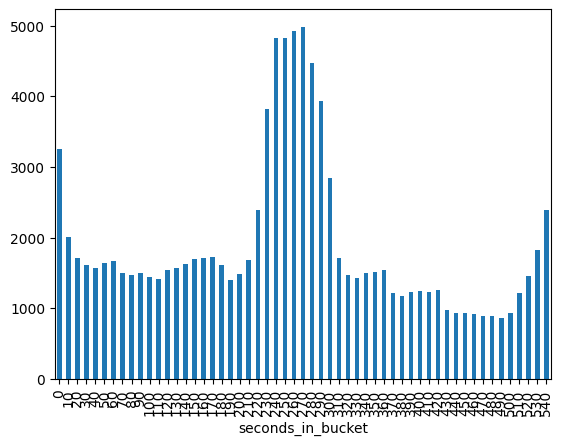

In [57]:
# select observations that have the target value at the tail end of the distribution, see if there is any pattern
target_seconds = raw_data[(raw_data['target'] > raw_data['target'].quantile(0.99))|(raw_data['target'] < raw_data['target'].quantile(0.01))].groupby('seconds_in_bucket').count()['target']
target_seconds.plot(kind='bar')

<Axes: xlabel='time_id'>

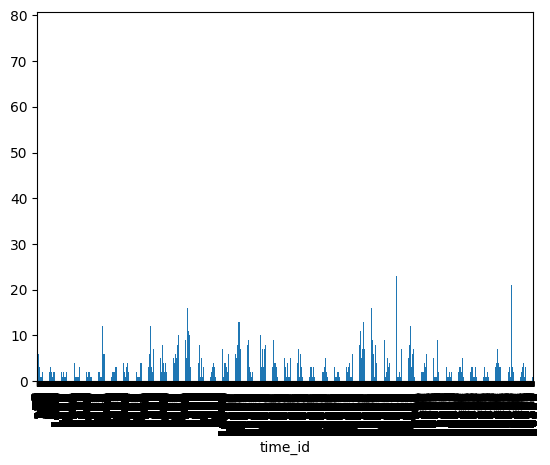

In [56]:
target_time_id = raw_data[(raw_data['target'] > raw_data['target'].quantile(0.99))|(raw_data['target'] < raw_data['target'].quantile(0.01))].groupby('time_id').count()['target']
target_time_id.plot(kind = 'bar')

### conclusion:
extreme targets have strong time dependency, and the time dependency is not linear.
large wave of extreme targets happen before the 300 second marker, righe before the ban of using market orders. hence demonstrated urgency of execution.

# Synthetic index
https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/442851
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
weights sum to 1
# for future improvement:
since we know there are days where the number of stocks are less than 200, and we know that within one day, the number of stocks doesn't change. We can do OLS with the same method but on a daily basis. 
since synthetic index is part of the target, we can do many things with it:
## 1. we can fill the missing target values

In [80]:
raw_data[raw_data['target'].isna()]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
369508,131,35,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1925,35_0_131
369700,131,35,10,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1926,35_10_131
369892,131,35,20,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1927,35_20_131
370084,131,35,30,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1928,35_30_131
370276,131,35,40,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1929,35_40_131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4225338,158,388,510,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,21391,388_510_158
4225538,158,388,520,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,21392,388_520_158
4225738,158,388,530,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,21393,388_530_158
4225938,158,388,540,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,21394,388_540_158


In [88]:
raw_data[(raw_data['stock_id']==131)& (raw_data['date_id']==35)]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
369508,131,35,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1925,35_0_131
369700,131,35,10,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1926,35_10_131
369892,131,35,20,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1927,35_20_131
370084,131,35,30,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1928,35_30_131
370276,131,35,40,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1929,35_40_131
370468,131,35,50,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1930,35_50_131
370660,131,35,60,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1931,35_60_131
370852,131,35,70,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1932,35_70_131
371044,131,35,80,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1933,35_80_131
371236,131,35,90,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1934,35_90_131


<Axes: xlabel='seconds_in_bucket'>

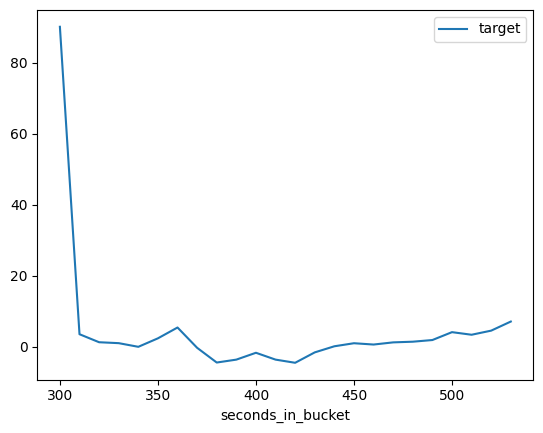

In [86]:
raw_data[(raw_data['stock_id']==131 )& (raw_data['date_id']==35)].loc[:,['target','seconds_in_bucket']].plot(x='seconds_in_bucket',y='target')

# Ideas:
1. volatility weighted synthetic index: Target computation have its own synthetic index computation component.
2. historica beta: correlation between stock and index
3. AR1: target usually bonce between two periods. 
4. volatility: historical volatility of the stock will continue
5. order book imbalance shift around: how many times order books imbalance changes, indicates disagreement between buyers and sellers.
6. order book imbalance shift magnitude: small difference shift doesn't matter if the magnitude is small.
7. seconds_in_bucket: how stocks always perform in the same 10 seconds -> indicates possible algorithmic trading.
8. seconds_in_bucket volatility: historically how volatile the stock is in the same 10 seconds.
9. maximum bonce in x seconds: give the algo a feeling of how normal range should be
10. near price - far price: the difference of the market running auction or the market running auction + continous market trading.
11. (near price-far price)/ (far price* second in bucket): the percentage of the market running auction or the market running auction + continous market trading. indicator of market inefficiency. adjust for seconds in bucket.
12. time 0 and time 540 might be special: time 0: people may not be ready to trade, but algos are. time 540: last chance to trade.
13. spoofing: "fake orders" posted design to build order imbalance, so that it encourages the buy/sell of the stock such that it goes in the direction of the spoofer's order.
variance of the order book imbalance suggests spoofing. since we cannot cancel after 3:50, we can only do spoofing with both side large order that cancel each other out.

14. Rough fill probability: the probability for the best bid-ask price being filled. 
t=0, bid-ask price = 100-101. bid-ask vol = 1000-1000 
t=1, bid-ask price = 100-101. bid-ask vol = 500-500
then rough fill probability for bid-ask = 0.5 0.5
15. stock agreeableness: if the matching size is large relative to the order book imbalance size (compare to the cross-sectional median), then the buyer and seller agree on the price 
16. volume sitting on the order book (less best-bid-and-ask) = imbalance size - bid_size-ask_size
16. wap sitting on the order book: because wap is weighted average price for all order sitting on the order book,so we can extract parts that is not the best bid and ask price
![Formular](./wap_sitting.jpg)
17. best slot1 imbalance size: same calculation as imbalance size
18. difference in imbalance size: (imbalance_size-matched_size)/(matched_size+imbalance_size)
19. spread: best ask price - best bid price. indicate the trading cost of crossing the spread.
20. spread volatility  
21. deviation of price from the closing price(price at the start of the day)
22. 

# Questions:
1. if a stock listed, will it exist for the whole day? Answer Yes
2. if a stock is listed, will it be delisted later? Answer No
3. is there any missing value in the target like this post suggested? https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/442145 
Answer: YES. 88 

In [ ]:
stock_count = raw_data.loc[:,['stock_id','date_id', 'time_id']].groupby(['date_id', 'time_id']).count().reset_index().loc[:,['stock_id','date_id']].groupby('date_id').mean()

In [ ]:
stock_count[stock_count['stock_id'] < 200].tail()

In [ ]:
for i in raw_data['stock_id'].unique():
    if raw_data[raw_data['stock_id'] == i].iloc[-1].loc['row_id']!=f'480_540_{i}':
        print(i)
# nothing printed so we are safe.

In [ ]:
raw_data[raw_data['target'].isna()]# well, we have no choice but to drop these observations.

In [ ]:
raw_data = raw_data[~raw_data['target'].isna()]

In [ ]:
plt.hist(raw_data['target'],bins=100)

In [ ]:
plt.hist(raw_data['imbalance_size'],bins=100)

In [ ]:
raw_data[~raw_data['far_price'].isna()]

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import public_timeseries_testing_util as utils

In [ ]:
env = utils.make_env()

In [ ]:
iter_test = env.iter_test()

In [ ]:
for (test, revealed_targets, sample_prediction) in iter_test:
    print(test)
    print('\n')
    print(revealed_targets)
    print('\n')
    print(sample_prediction)
    print('\n')
    break

In [ ]:
input_paths = [r'train.csv',r'./example_test_files/test.csv']
dataframes = []
for pth in input_paths:
    dataframes.append(pd.read_csv(pth, low_memory=False))

In [ ]:
group_order = dataframes[0]['row_id'].drop_duplicates().tolist()
dataframes = [df.set_index('row_id') for df in dataframes]